## CS441: Applied ML - HW 2

### Parts 1-2: MNIST

Include all the code for generating MNIST results below

In [80]:
# initialization code
import numpy as np
from keras.datasets import mnist
%matplotlib inline
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
import cache_magic

def load_mnist():
  '''
  Loads, reshapes, and normalizes the data
  '''
  (x_train, y_train), (x_test, y_test) = mnist.load_data() # loads MNIST data
  x_train = np.reshape(x_train, (len(x_train), 28*28))  # reformat to 768-d vectors
  x_test = np.reshape(x_test, (len(x_test), 28*28))
  maxval = x_train.max()
  x_train = x_train/maxval  # normalize values to range from 0 to 1
  x_test = x_test/maxval
  return (x_train, y_train), (x_test, y_test)

def display_mnist(x, subplot_rows=1, subplot_cols=1):
  '''
  Displays one or more examples in a row or a grid
  '''
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

### Part 1: PCA and Data Compression

Loading cached value for variable 'pca1a'. Time since caching: 8 days, 1:38:03.816843
(10, 784)


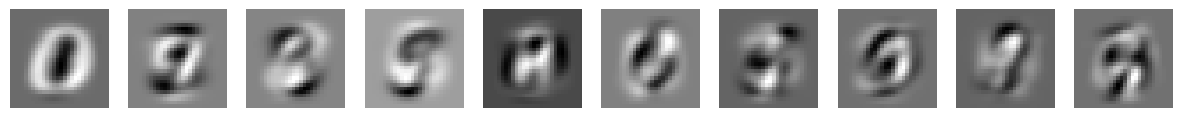

In [81]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = load_mnist()

# Compute the first 10 principal components using x_train

%cache pca1a = PCA(n_components=10).fit(x_train)

print(pca1a.components_.shape)
# Display First 10 Components
display_mnist(pca1a.components_, subplot_rows=1, subplot_cols=10)


Loading cached value for variable 'pca1b'. Time since caching: 8 days, 1:40:06.955217


<Axes: >

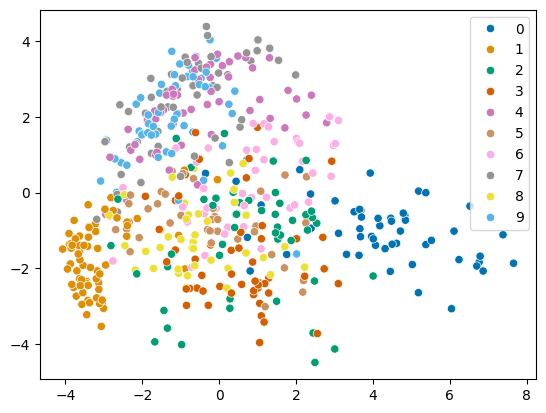

In [82]:
# Scatter plot of first two PCA dimensions
import seaborn as sns

# use pca.transform
%cache pca1b = PCA(n_components=2).fit(x_train)
x = pca1b.transform(x_train[:500])
ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind")

Loading cached value for variable 'pca1c'. Time since caching: 8 days, 1:37:55.480961


<Axes: xlabel='ith_component', ylabel='cumulative explained variance'>

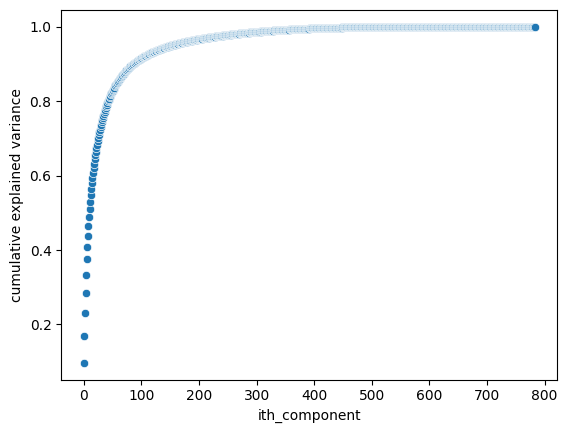

In [83]:
# Plot cumulative explained variance ratio
# cumsum and pca.explained_variance_ratio_ will be useful

%cache pca1c = PCA().fit(x_train)
cumul = np.cumsum(pca1c.explained_variance_ratio_)
sns.scatterplot(
    data = {
        "ith_component": np.arange(0, len(cumul), 1),
        "cumulative explained variance": cumul
    },
    x = "ith_component",
    y = "cumulative explained variance"
)

In [84]:
# Select number of dimensions that explains 90% of variance, according to your plot above
# !apt install libomp-dev > /dev/null 2>&1
# !pip install faiss-cpu > /dev/null 2>&1
import faiss
import time

# plus 1 because of 0 indexing
M = np.argwhere(cumul >= 0.9)[0].item() + 1
print(f"M = {M}")

# compress training data and test data
%cache pca1d = PCA(n_components=M).fit(x_train)
compressed_train, compressed_test = pca1d.transform(x_train), pca1d.transform(x_test)

def create_and_add(dim, data):
    idx = faiss.IndexFlatL2(dim)
    idx.add(data)
    return idx
# Get time and error when using original features with brute force 1-NN
%cache original_index = create_and_add(x_train.shape[1], x_train)
t1 = time.time()
dist, prediction = original_index.search(x_test, 1)
t2 = time.time()
timing = t2 - t1
# prediction = y_train[prediction]
# error = prediction[prediction != y_test.reshape(-1, 1)].sum() / len(prediction) * 100
error = np.mean(y_train[prediction.flatten()] != y_test) * 100
print(f"original error = {error}% | time = {timing}")
# print(np.mean(dist))

# Get time and error when using compressed features with brute force 1-NN
%cache comp_index = create_and_add(compressed_train.shape[1], compressed_train)
t1 = time.time()
dist, prediction = comp_index.search(compressed_test, 1)
t2 = time.time()
timing = t2 - t1
# prediction = y_train[prediction]
error = np.mean(y_train[prediction.flatten()] != y_test) * 100
print(f"compressed error = {error}% | time = {timing}")
# print(np.mean(dist))



M = 87
Loading cached value for variable 'pca1d'. Time since caching: 8 days, 1:37:52.756670
Loading cached value for variable 'original_index'. Time since caching: 8 days, 1:37:50.756619
original error = 3.09% | time = 5.727076530456543
Loading cached value for variable 'comp_index'. Time since caching: 8 days, 1:37:50.332103
compressed error = 2.68% | time = 1.317983627319336


In [85]:
%cache

Var Name,Size(MB),Stored Date,Version,Expression
best_svm_model,0.047763,2024-02-11 22:25:12.910938,0,"svm.LinearSVC(max_iter=10000, dual='auto', C=0.02).fit(x_train2c, y_train2c)"
comp_index,19.4972,2024-02-11 12:33:37.476982,0,"create_and_add(compressed_train.shape[1], compressed_train)"
llr_estimators,0.196202,2024-02-11 12:34:18.190520,0,train_llr()
normalized_ridge,0.003595,2024-02-13 13:49:12.683891,0,"Ridge().fit(x_train_norm, y_train_norm)"
original_index,15.7322,2024-02-11 12:33:30.965873,0,"create_and_add(x_train.shape[1], x_train)"
original_ridge,0.003609,2024-02-13 13:41:16.879345,0,"Ridge().fit(x_train, y_train)"
p4bllrel,0.015978,2024-02-13 19:38:33.338921,0,"LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5).fit(x_train[:N], y_train[:N])"
p4bllrl1,0.009957,2024-02-13 19:37:14.924169,0,"LogisticRegression(solver='saga', penalty='l1').fit(x_train[:N], y_train[:N])"
p4bllrl2,0.048246,2024-02-13 19:37:17.938963,0,"LogisticRegression(solver='saga', penalty='l2').fit(x_train[:N], y_train[:N])"
p4ctsne,0.004283,2024-02-13 19:54:09.135682,0,TSNE().fit(x_train[:500])


### Part 2: MNIST Classification with Linear Models

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score

LLR/SVM vs training size

In [87]:
# LLR
sizes = [100, 1000, 10000, 60000]
train_llr = lambda: [LogisticRegression(max_iter=10000).fit(x_train[:sz], y_train[:sz]) for sz in sizes]
%cache llr_estimators = train_llr()
print([1 - accuracy_score(llr.predict(x_test), y_test) for llr in llr_estimators])


Loading cached value for variable 'llr_estimators'. Time since caching: 8 days, 1:37:11.062065
[0.32499999999999996, 0.13639999999999997, 0.09499999999999997, 0.07389999999999997]


In [88]:
# SVM
train_svm = lambda: [svm.LinearSVC(max_iter=10000, dual='auto').fit(x_train[:sz], y_train[:sz]) for sz in sizes]
%cache svm_estimators = train_svm()
errors = [(svm.predict(x_test) != y_test).sum() / len(y_test) * 100 for svm in svm_estimators]
print([1 - accuracy_score(svm.predict(x_test), y_test) for svm in svm_estimators])

Loading cached value for variable 'svm_estimators'. Time since caching: 7 days, 23:17:33.032995
[0.3235, 0.16110000000000002, 0.11119999999999997, 0.0817]


Error visualization

LLR high and low confidence


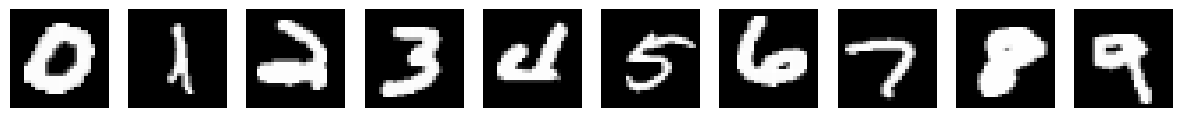

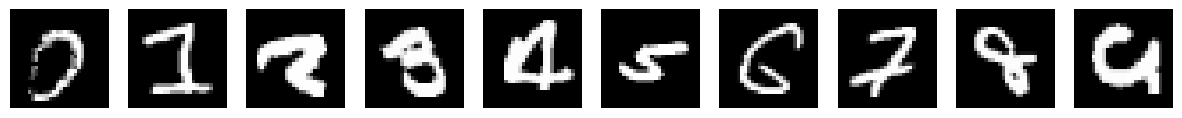

SVM high and low confidence


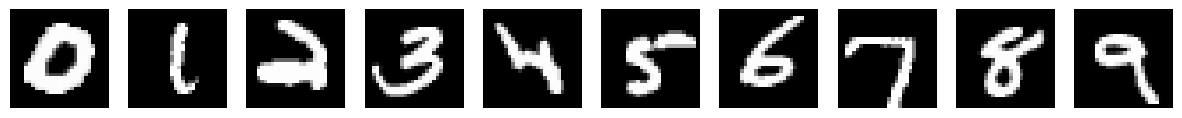

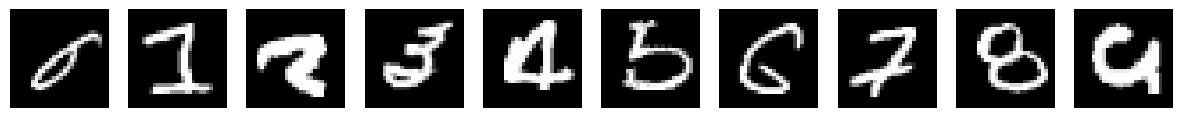

In [89]:
scores = llr_estimators[-1].predict_proba(x_test)

llrhigh, llrlow = [], []
for cls in range(10):
    # get samples with true label of class
    cls_sample = x_test[y_test == cls]
    # get their scores
    cls_sample_scores = scores[y_test == cls][:, cls]
    # show
    llrhigh.append(cls_sample[np.argmax(cls_sample_scores)])
    llrlow.append(cls_sample[np.argmin(cls_sample_scores)])
    
print("LLR high and low confidence")
display_mnist(llrhigh, subplot_rows=1, subplot_cols=10)
display_mnist(llrlow, subplot_rows=1, subplot_cols=10)

scores = svm_estimators[-1].decision_function(x_test)
svmhigh, svmlow = [], []
for cls in range(10):
    # get samples with true label of class
    cls_sample = x_test[y_test == cls]
    # get their scores
    cls_sample_scores = scores[y_test == cls][:, cls]
    # show
    svmhigh.append(cls_sample[np.argmax(cls_sample_scores)])
    svmlow.append(cls_sample[np.argmin(cls_sample_scores)])
    
print("SVM high and low confidence")
display_mnist(svmhigh, subplot_rows=1, subplot_cols=10)
display_mnist(svmlow, subplot_rows=1, subplot_cols=10)

Parameter selection

Text(0, 0.5, 'validation error')

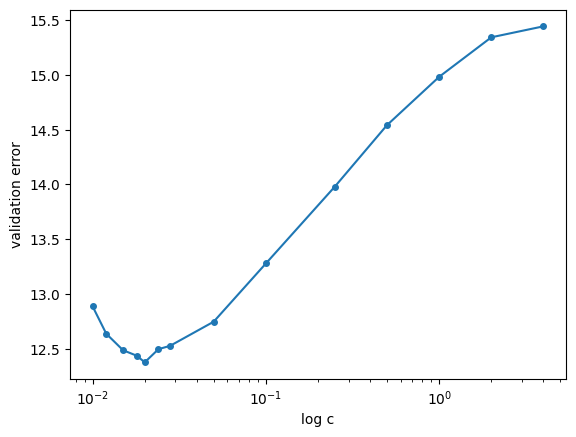

In [90]:
# Try multiple C parameters, select one that minimizes validation error
# Often, you need to try a few values and see those results to determine what other values to try

get_error = lambda pred, y: (pred != y).sum() / len(y) * 100
C = [0.01, 0.012, 0.015, 0.018, 0.02, 0.024, 0.028, 0.05, 0.1, 0.25, 0.5, 1, 2, 4]
x_train2c, x_val2c = x_train[:1000], x_train[50000:]
y_train2c, y_val2c = y_train[:1000], y_train[50000:]
val_err = []
for c in C:
    model = svm.LinearSVC(max_iter=10000, dual='auto', C=c)
    model.fit(x_train2c, y_train2c)
    val_err.append(get_error(model.predict(x_val2c), y_val2c))
plt.semilogx(C, val_err, marker='o', markersize=4)
plt.xlabel('log c')
plt.ylabel('validation error')

In [91]:
# Get test result for selected parameter
%cache best_svm_model = svm.LinearSVC(max_iter=10000, dual='auto', C=0.02).fit(x_train2c, y_train2c)
print(f"Validation error: {get_error(best_svm_model.predict(x_val2c), y_val2c)}")
print(f"Test error: {get_error(best_svm_model.predict(x_test), y_test)}")

Loading cached value for variable 'best_svm_model'. Time since caching: 7 days, 15:46:20.024406
Validation error: 12.379999999999999
Test error: 13.569999999999999


## Part 3: Temperature Regression


In [92]:
import numpy as np
# from google.colab import drive
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# load data (modify to match your data directory or comment)
def load_temp_data():
  datadir = "./"
  T = np.load(datadir + 'temperature_data.npz')
  x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day = \
  T['x_train'], T['y_train'], T['x_val'], T['y_val'], T['x_test'], T['y_test'], T['dates_train'], T['dates_val'], T['dates_test'], T['feature_to_city'], T['feature_to_day']
  return (x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day)

# plot one data point for listed cities and target date
def plot_temps(x, y, cities, feature_to_city, feature_to_day, target_date):
  nc = len(cities)
  ndays = 5
  xplot = np.array([-5,-4,-3,-2,-1])
  yplot = np.zeros((nc,ndays))
  for f in np.arange(len(x)):
    for c in np.arange(nc):
      if cities[c]==feature_to_city[f]:
        yplot[feature_to_day[f]+ndays,c] = x[f]
  plt.plot(xplot,yplot)
  plt.legend(cities)
  plt.plot(0, y, 'b*', markersize=10)
  plt.title('Predict Temp for Cleveland on ' + target_date)
  plt.xlabel('Day')
  plt.ylabel('Avg Temp (C)')
  plt.show()


Feature 361: city = Cleveland, day= -1
Baseline - prediction using previous day: RMSE=3.460601246750482


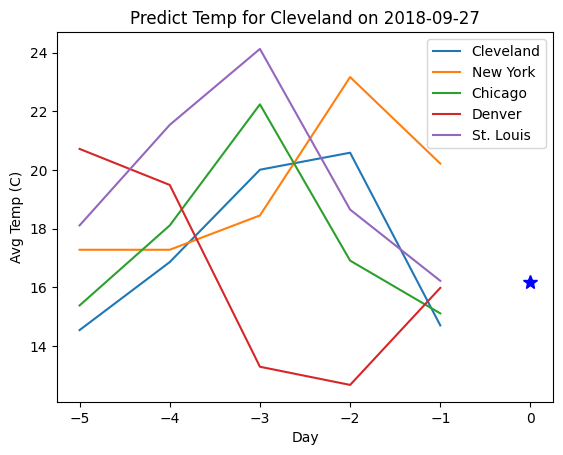

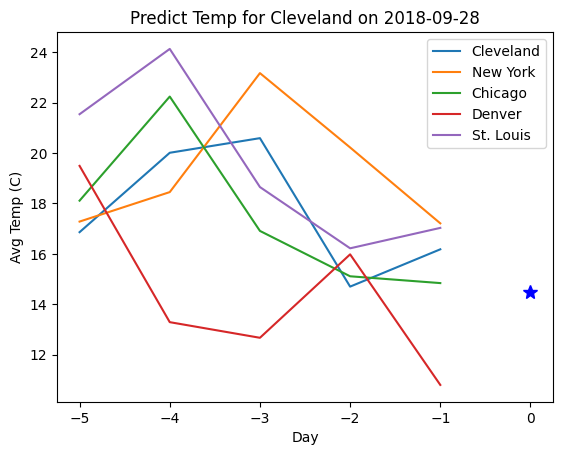

In [93]:
# load data
(x_train, y_train, x_val, y_val, x_test, y_test, dates_train, dates_val, dates_test, feature_to_city, feature_to_day) = load_temp_data()
''' Data format:
      x_train, y_train: features and target value for each training sample (used to fit model)
      x_val, y_val: features and target value for each validation sample (used to select hyperparameters, such as regularization and K)
      x_test, y_test: features and target value for each test sample (used to evaluate final performance)
      dates_xxx: date of the target value for the corresponding sample
      feature_to_city: maps from a feature number to the city
      feature_to_day: maps from a feature number to a day relative to the target value, e.g. -2 means two days before
      Note: 361 is the temperature of Cleveland on the previous day
'''
f = 361
print('Feature {}: city = {}, day= {}'.format(f,feature_to_city[f], feature_to_day[f]))
baseline_rmse = np.sqrt(np.mean((y_val[1:]-y_val[:-1])**2)) # root mean squared error
print('Baseline - prediction using previous day: RMSE={}'.format(baseline_rmse))

# plot first two x/y for val
plot_temps(x_val[0], y_val[0], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[0])
plot_temps(x_val[1], y_val[1], ['Cleveland', 'New York', 'Chicago', 'Denver', 'St. Louis'], feature_to_city, feature_to_day, dates_val[1])



Linear regression test

In [94]:
def normalize_features(x, y, fnum):
  ''' Normalize the features in x and y.
      For each data sample i:
        x2[i] = x[i]-x[i,fnum]
        y2[i] = y[i]-x[i,fnum]
  '''
  x2 = x.copy()
  y2 = y.copy()
  for i in np.arange(len(x)):
    x2[i] = x[i] - x[i, fnum]
    y2[i] = y[i] - x[i,fnum]
  return x2, y2

In [95]:
F = 361
from sklearn.metrics import root_mean_squared_error
# linear regression (use Ridge)
# original features
%cache original_ridge = Ridge().fit(x_train, y_train)
print(f"original features rmse: {np.sqrt(np.mean((original_ridge.predict(x_test) - y_test) ** 2))}")
# normalized features
(x_train_norm, y_train_norm), (x_test_norm, y_test_norm) = normalize_features(x_train, y_train, F), normalize_features(x_test, y_test, F)
%cache normalized_ridge = Ridge().fit(x_train_norm, y_train_norm)
print(f"normalized features rmse: {np.sqrt(np.mean((normalized_ridge.predict(x_test_norm) - y_test_norm) ** 2))}")

Loading cached value for variable 'original_ridge'. Time since caching: 6 days, 0:30:16.487390
original features rmse: 2.160860526080926
Loading cached value for variable 'normalized_ridge'. Time since caching: 6 days, 0:22:20.693291
normalized features rmse: 2.1630698027573665


Feature selection

In [96]:
# feature analysis (select important features using Lasso)
lasso = Lasso().fit(x_train, y_train)
lasso_indices = [(i, v) for i, v in enumerate(np.abs(lasso.coef_)) if v > 0.001]
lasso_indices.sort(key = lambda x: x[1], reverse=True)
top10_indices = [x[0] for x in lasso_indices[:10]]
print(f"Top 10: {top10_indices}")
print(f"Top 10 cities: {[feature_to_city[x] for x in top10_indices]}")
print(f"Top 10 days: {[feature_to_day[x] for x in top10_indices]}")

# predict using best features
selected_indices = [x[0] for x in lasso_indices]
root_mean_squared_error(
    Ridge().fit(
        np.take(x_train, selected_indices, axis=1), y_train)
        .predict(np.take(x_test, selected_indices, axis=1))
    , y_test
)

Top 10: [334, 347, 405, 366, 361, 307, 367, 264, 9, 236]
Top 10 cities: ['Chicago', 'Minneapolis', 'Grand Rapids', 'Kansas City', 'Cleveland', 'Omaha', 'Indianapolis', 'Minneapolis', 'Boston', 'Springfield']
Top 10 days: [-1, -1, -1, -1, -1, -2, -1, -2, -5, -3]


2.0579879892446384

In [97]:
%cache

Var Name,Size(MB),Stored Date,Version,Expression
best_svm_model,0.047763,2024-02-11 22:25:12.910938,0,"svm.LinearSVC(max_iter=10000, dual='auto', C=0.02).fit(x_train2c, y_train2c)"
comp_index,19.4972,2024-02-11 12:33:37.476982,0,"create_and_add(compressed_train.shape[1], compressed_train)"
llr_estimators,0.196202,2024-02-11 12:34:18.190520,0,train_llr()
normalized_ridge,0.003595,2024-02-13 13:49:12.683891,0,"Ridge().fit(x_train_norm, y_train_norm)"
original_index,15.7322,2024-02-11 12:33:30.965873,0,"create_and_add(x_train.shape[1], x_train)"
original_ridge,0.003609,2024-02-13 13:41:16.879345,0,"Ridge().fit(x_train, y_train)"
p4bllrel,0.015978,2024-02-13 19:38:33.338921,0,"LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5).fit(x_train[:N], y_train[:N])"
p4bllrl1,0.009957,2024-02-13 19:37:14.924169,0,"LogisticRegression(solver='saga', penalty='l1').fit(x_train[:N], y_train[:N])"
p4bllrl2,0.048246,2024-02-13 19:37:17.938963,0,"LogisticRegression(solver='saga', penalty='l2').fit(x_train[:N], y_train[:N])"
p4ctsne,0.004283,2024-02-13 19:54:09.135682,0,TSNE().fit(x_train[:500])


## Part 4: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

##### a) PR and ROC curves

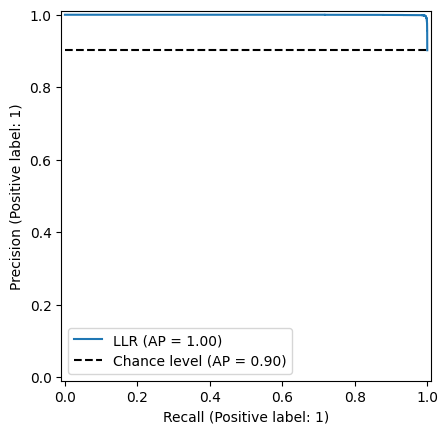

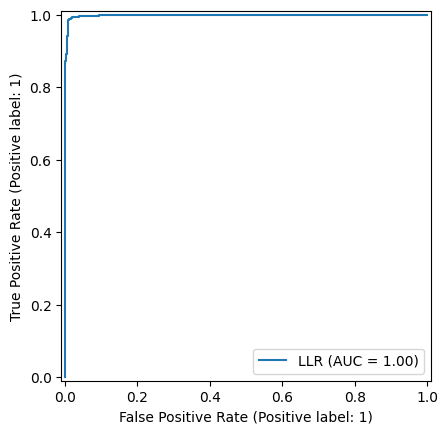

In [98]:
(x_train, y_train), (x_test, y_test) = load_mnist()
# change label to 0 or 1
p4a_y_train = y_train.copy()
p4a_y_train[p4a_y_train > 0] = 1
p4a_y_test = y_test.copy()
p4a_y_test[p4a_y_test > 0] = 1

p4allr = LogisticRegression().fit(x_train, p4a_y_train)
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
PrecisionRecallDisplay.from_estimator(
    p4allr, x_test, p4a_y_test, name="LLR", plot_chance_level=True
)
RocCurveDisplay.from_estimator(
    p4allr, x_test, p4a_y_test, name="LLR"
)

##### b) Visualize weights

Loading cached value for variable 'p4bllrl1'. Time since caching: 5 days, 18:34:20.956202
Loading cached value for variable 'p4bllrl2'. Time since caching: 5 days, 18:34:17.953454
Loading cached value for variable 'p4bllrel'. Time since caching: 5 days, 18:33:02.574848


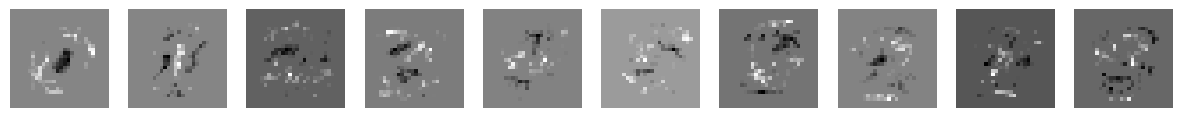

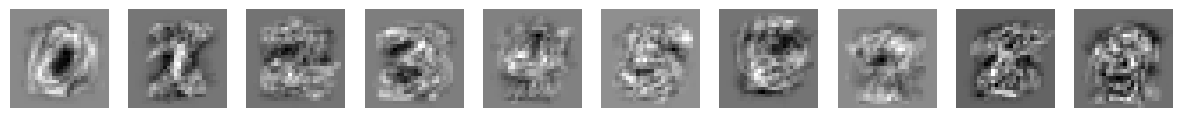

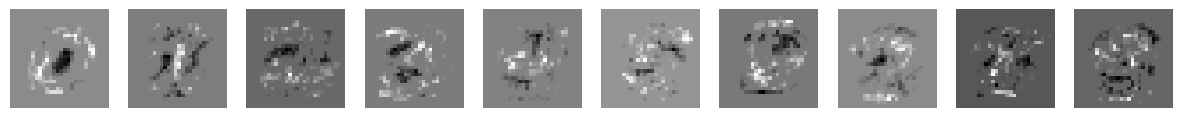

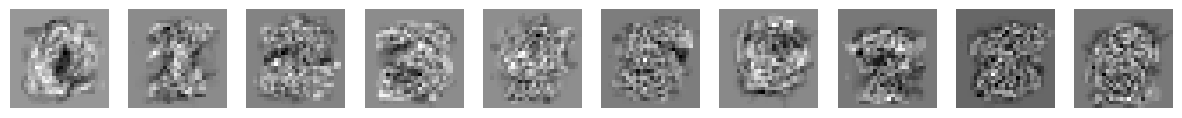

In [99]:
# train using fewer samples
N = 1000
%cache p4bllrl1 = LogisticRegression(solver='saga', penalty='l1').fit(x_train[:N], y_train[:N])
%cache p4bllrl2 = LogisticRegression(solver='saga', penalty='l2').fit(x_train[:N], y_train[:N])
%cache p4bllrel = LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=.5).fit(x_train[:N], y_train[:N])

display_mnist(p4bllrl1.coef_, subplot_rows=1, subplot_cols=10)
display_mnist(p4bllrl2.coef_, subplot_rows=1, subplot_cols=10)
display_mnist(p4bllrel.coef_, subplot_rows=1, subplot_cols=10)

p4bsvm = svm.LinearSVC(dual='auto').fit(x_train[:N], y_train[:N])
display_mnist(p4bsvm.coef_, subplot_rows=1, subplot_cols=10)

##### c) Other embeddings

[Text(0.5, 1.0, 'PCA')]

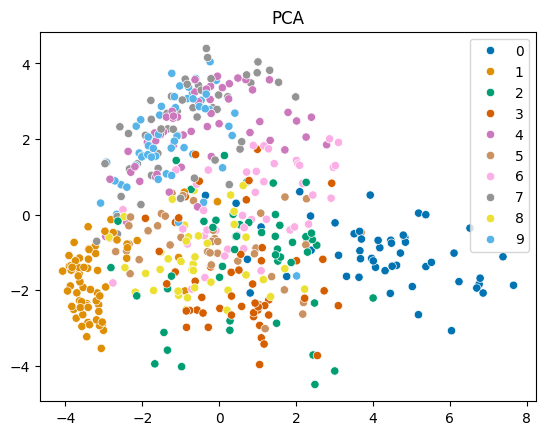

In [100]:
x = pca1b.transform(x_train[:500])
ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind").set(title='PCA')

[Text(0.5, 1.0, 'TSNE')]

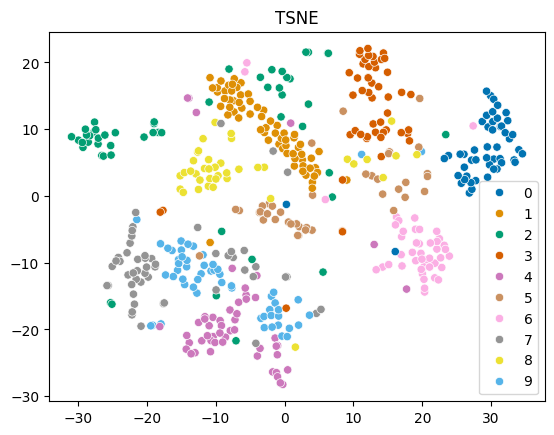

In [101]:
from sklearn.manifold import TSNE
p4ctsne = TSNE()
x = p4ctsne.fit_transform(x_train[:500])
ind = np.arange(500)
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind").set(title='TSNE')

[Text(0.5, 1.0, 'LDA')]

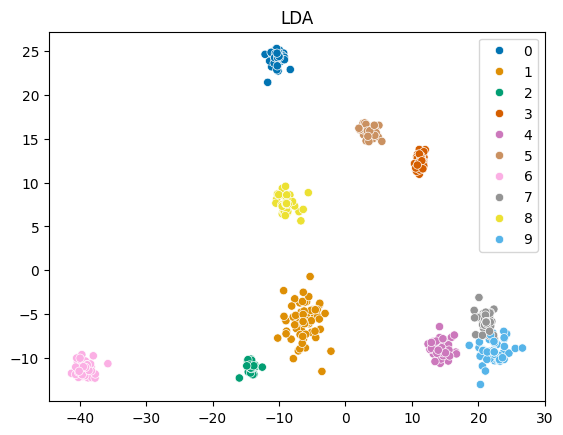

In [102]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
p4clda = LinearDiscriminantAnalysis(n_components=2).fit(x_train[:500], y_train[:500])
x = p4clda.transform(x_train[:500])
sns.scatterplot(x=x[ind,0],y=x[ind,1], hue=y_train[ind], palette="colorblind").set(title='LDA')

##### e) SVM with RBF Kernel

In [103]:
print([accuracy_score(llr.predict(x_test), y_test) for llr in llr_estimators])

sizes = [100, 1000, 10000, 60000]
train_svmrbf = lambda : [svm.SVC(kernel='rbf').fit(x_train[:sz], y_train[:sz]) for sz in sizes]
%cache svmrbf_estimators = train_svmrbf()
score_svmrbf = lambda : [accuracy_score(svm.predict(x_test), y_test) for svm in svmrbf_estimators]
%cache svmrbfscores = score_svmrbf()
print(svmrbfscores)

[0.675, 0.8636, 0.905, 0.9261]
Loading cached value for variable 'svmrbf_estimators'. Time since caching: 5 days, 17:37:32.071795
Loading cached value for variable 'svmrbfscores'. Time since caching: 5 days, 17:30:58.110247
[0.6559, 0.9083, 0.9594, 0.9792]


In [104]:
%cache

Var Name,Size(MB),Stored Date,Version,Expression
best_svm_model,0.047763,2024-02-11 22:25:12.910938,0,"svm.LinearSVC(max_iter=10000, dual='auto', C=0.02).fit(x_train2c, y_train2c)"
comp_index,19.4972,2024-02-11 12:33:37.476982,0,"create_and_add(compressed_train.shape[1], compressed_train)"
llr_estimators,0.196202,2024-02-11 12:34:18.190520,0,train_llr()
normalized_ridge,0.003595,2024-02-13 13:49:12.683891,0,"Ridge().fit(x_train_norm, y_train_norm)"
original_index,15.7322,2024-02-11 12:33:30.965873,0,"create_and_add(x_train.shape[1], x_train)"
original_ridge,0.003609,2024-02-13 13:41:16.879345,0,"Ridge().fit(x_train, y_train)"
p4bllrel,0.015978,2024-02-13 19:38:33.338921,0,"LogisticRegression(solver='saga', penalty='elasticnet', l1_ratio=0.5).fit(x_train[:N], y_train[:N])"
p4bllrl1,0.009957,2024-02-13 19:37:14.924169,0,"LogisticRegression(solver='saga', penalty='l1').fit(x_train[:N], y_train[:N])"
p4bllrl2,0.048246,2024-02-13 19:37:17.938963,0,"LogisticRegression(solver='saga', penalty='l2').fit(x_train[:N], y_train[:N])"
p4ctsne,0.004283,2024-02-13 19:54:09.135682,0,TSNE().fit(x_train[:500])


In [105]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

# import os
# # @title Convert Notebook to PDF. Save Notebook to given directory
# NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
# NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
# #------------------------------------------------------------------------------#
# from google.colab import drive
# drive.mount("/content/drive/", force_remount=True)
# NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
# assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
# !apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
# !jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
# NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
# assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
# print(f"PDF CREATED: {NOTEBOOK_PDF}")